Example dataset-1 from [TensorFlow Speech Recognition Challenge](https://www.tensorflow.org/tutorials/sequences/audio_recognition) <br>
I will go through shared kernels. 


Resources:
* Most popular data exploration [kernel](https://www.kaggle.com/davids1992/speech-representation-and-data-exploration) on kaggle
* Tensorflow simple audio [tutorial](https://www.tensorflow.org/tutorials/sequences/audio_recognition)
* Google Research [Blog Post](https://ai.googleblog.com/2017/08/launching-speech-commands-dataset.html) announcing the Speech Commands Dataset.


In [1]:
import os
from scipy.io import wavfile
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# FOR ORIGINAL DATASET FROM GOOGLE

# # Download data
# # Dataset is updated (April 11th 2018) after the competition, we will use old version 
# version="0.01" #65,000 audio file
# # version="0.02" #105,829 audio files

# data_folder='../data/'
# speech_folder_path="../data/speech_commands_v"+version+"/"

# data_url="http://download.tensorflow.org/data/speech_commands_v"+version+".tar.gz"
# data_file=data_folder+"speech_commands_v"+version+".tar.gz"

# # Create  a folder for data
# if not os.path.exists(data_folder):
#     os.makedirs(data_folder)
# if not os.path.exists(speech_folder_path):
#     os.makedirs(speech_folder_path)

# # Download dataset
# !wget -O $data_file $data_url
# !tar -xzf $data_file --directory=$speech_folder_path


#DOWNLOAD FROM KAGGLE (requires kaggle api key)

# !kaggle competitions download -c tensorflow-speech-recognition-challenge
# !7z x -o../data/speech_comands_kaggle ./test.7z > /dev/null
# !7z x -o../data/speech_comands_kaggle ./train.7z > /dev/null

In [3]:
# takes hours on single cpu
# !7z x -o../data/speech_comands_kaggle2 ./test.7z > /dev/null
# !7z x -o../data/speech_comands_kaggle2 ./train.7z > /dev/null

# Dataset 
It includes 65,000 audio files, one-second long utterances of 30 short words, by thousands of different people. <br>
Such as "yes","no","up" ..<br>
data folder "speech_commands" includes folders named after each command<br>
>./data
>>/speech_commands_kaggle
>>>/train
>>>>/audio
>>>>>/yes
>>>>>>0a7c2a8d_nohash_0.wav

>>>>>/no

0a7c2a8d_nohash_0.wav:  0a7c2a8d --> speaker's id, nohash for sorting reasons, 0 means first utterance of that word by this speaker in the data set  
Chechout ../data/speech_commands/README.md for details

Sound data is in the form of amplitude X time format,  
however this is not really helpful to differentiate them one from another  
Solution is finding amplitude per frequency so we will have amplitude x frequency which we can get with fourier transform  
Then we loose time domain, all time domain smashed into one point.  
As a solution we pick time windows and take forier transform of those windowes,  
Then problem is some of the patters might be longer than our window size.  
As a solution we can have overlapping windowses.

Check course slides for details: [https://hyp.is/go?url=http%3A%2F%2Fm.mr-pc.org%2Ft%2Fcsc83060%2F2019sp%2Flecture02.pdf](https://hyp.is/go?url=http%3A%2F%2Fm.mr-pc.org%2Ft%2Fcsc83060%2F2019sp%2Flecture02.pdf)

In [17]:
# 
# if you think a signal with sampling frequency of 1,000 (fs)
fs=10e3
# lets say there N samples
N = 1e5
# our amplitude is 2*2*(1/2) = 2.82
amp = 2 * np.sqrt(2)

#lets get some nouse also 
noise_power = 0.01 * fs / 2

# our time array will have stamps for each 1/fs second, if we have N samples, Nth sample is collected at N/sampling_rate time
# so our time array have seconds, each 1000th sample is collected at the end of the 1 second cycle
time = np.arange(N) / float(fs)
# cos(pi*k) cycles with every time k=0,2,4,6 etc
# cos(pi*k*0.5) cycles with every time k=0,4,8,12 etc
mod = 500*np.cos(2*np.pi*0.25*time)

# np.sin(2*np.pi*3e3*k) cycles every 500 value of k,
# np.sin(2*np.pi*3e3*time so time values turned into a signal of repeating 
carrier = amp * np.sin(2*np.pi*3e3*time + mod)

# use normal disribution to generate noise
noise = np.random.normal(scale=np.sqrt(noise_power), size=time.shape)
# I do not know why we need this , probably to keep noise low compared to signal
noise *= np.exp(-time/5)

x = carrier + noise

In [52]:
# now 
print("length of x is",len(x),"\nx is",x[0:10])
f, t, Sxx = signal.spectrogram(x, fs)

# f is array of sample frequencies
print(len(f))
# t is Array of segment times.
print(len(t))
# Sxx is spectrogram of x. By default, the last axis of Sxx corresponds to the segment times.
Sxx[0][0]
print(Sxx.shape)

length of x is 100000 
x is [  2.53492786  -9.67722294   3.15398682 -14.76250538  18.75035472
   1.62951273  15.46248616  -0.52130691  -1.65799645  -0.50676498]
129
446
(129, 446)


Text(0.5,0,'Time [sec]')

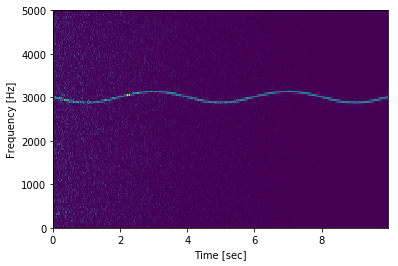

In [55]:
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

Text(0.5,0,'Time [sec]')

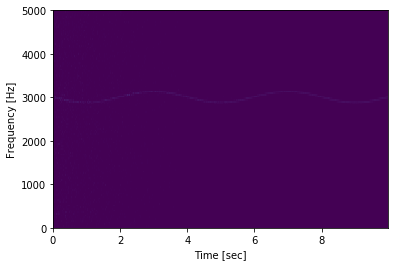

In [56]:
plt.pcolormesh(t, f, Sxx,vmin=0, vmax=amp)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

In [20]:
# TODO-Q : I do understand all parameters of scipy.signal.spectrogram or scipy.signal.stft
# TODO-Q : I do not know why spectram is different then stft

In [48]:
f,t,Zxx=signal.stft(x,fs,nperseg=1000,)

TypeError: stft() got an unexpected keyword argument 'vmin'

In [42]:
len(f)
len(t)

201

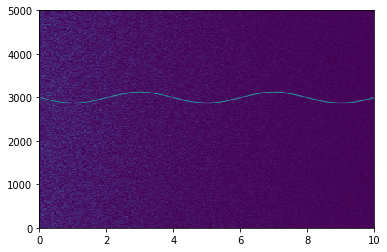

In [46]:
plt.pcolormesh(t, f, np.abs(Zxx),vmin=0, vmax=amp)


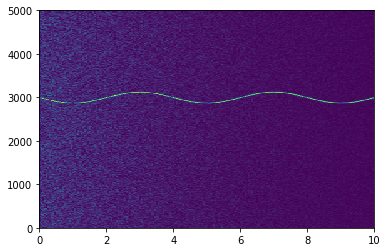

In [47]:
plt.pcolormesh(t, f, np.abs(Zxx))


Lets get a sound file and look into spectrum of it:

In [4]:
train_audio_path = "../data/speech_comands_kaggle/train/audio/"
filename = "yes/004ae714_nohash_0.wav"
# speech_audio_understanding/data/speech_comands_kaggle/train/audio/yes/004ae714_nohash_0.wav

# scipy.io have wavfile functio to read vaw files
# returns a int and numpy array
sample_rate, samples = wavfile.read(train_audio_path+filename)

Sample_rate is 16,000 for all files so length of samples array is 16k

Lets look into spectogram and Short Time Fourier Transform functions of Scipy to understand them

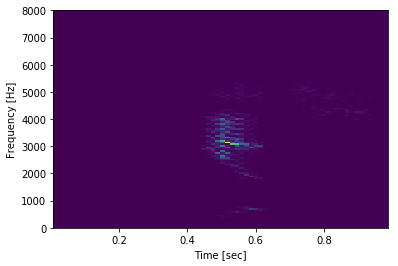

In [57]:
f, t, Sxx = signal.spectrogram(samples, sample_rate)
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

This function takes log of the data and changes parameters of the spectogram slightly, so we can see the signla more clearly

In [58]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

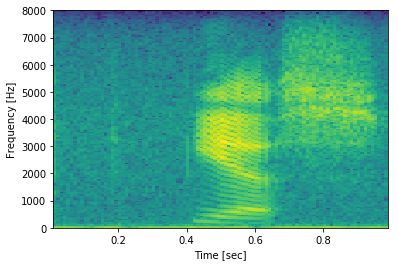

In [60]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)
# f, t, Sxx = signal.spectrogram(freqs, sample_rate)
plt.pcolormesh(times, freqs, spectrogram.T)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

TODO-Q what is best feature, what is used in general with NN ?  
Spectogram, mel power spectogram
